In [13]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random

from safetensors import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.io import read_image
import torch

In [14]:
img_h = 1080
img_w = 1920

In [15]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device available")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device available")
else:
    device = torch.device("cpu")
    print("CPU device available")

CUDA device available


In [32]:
train_dir_v1 = './data/object_detection_v1/train/'
val_dir_v1 = './data/object_detection_v1/val/'

train_dir_v2 = './data/object_detection_v2/train/'
val_dir_v2 = './data/object_detection_v2/val/'

test_dir = '../train/Task1/'

In [33]:
test_img_paths = os.listdir(test_dir)
test_paths = []
for path in test_img_paths:
    if path.endswith('.jpg'):
        test_paths.append(path)

In [18]:
def compute_iou(boxA, boxB):
    # boxA and boxB are tuples/lists representing bounding boxes in the format (x1, y1, x2, y2)
    # where (x1, y1) are the coordinates of the top-left corner
    # and (x2, y2) are the coordinates of the bottom-right corner

    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate the area of intersection rectangle
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of the individual bounding boxes
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate the area of union
    union_area = boxA_area + boxB_area - intersection_area

    # Calculate IOU
    iou = intersection_area / union_area

    return iou

In [19]:
def generate_bounding_box(img_h, img_w):
    try:
        x1_range = (0, img_w - 1)
        x1 = random.randint(*x1_range)
        
        x2_range = (x1 + 100, img_w)
        x2 = random.randint(*x2_range)
        
        y1_range = (0, img_h - 1)
        y1 = random.randint(*y1_range)
        
        y2_range = (y1 + 60, img_h)
        y2 = random.randint(*y2_range)

        return x1, y1, x2, y2
    except ValueError:
        return generate_bounding_box(img_h, img_w)

In [20]:
class ObjectDetectionDatasetV1(Dataset):
    def __init__(self, root):
        self.root = root
        self.images = list(sorted(os.listdir(self.root + 'images/')))
        self.labels = list(sorted(os.listdir(self.root + 'labels/')))
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = read_image(self.root + 'images/' + self.images[idx]).float() / 255.0
        color_chanels, image_height, image_width = img.shape
        
        label_path = self.root + 'labels/'+ self.labels[idx]
        boxes = []
        labels = []
        
        # Positive examples
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                _, x_center, y_center, width, height = map(float, data)
                
                # Convert relative coordinates to absolute coordinates
                x_center *= image_width
                y_center *= image_height
                width *= image_width
                height *= image_height
                
                # Calculate top-left and bottom-right coordinates
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                if (x2 > x1 and 
                        y2 > y1 and 
                        0 <= x1 < image_width and 
                        0 <= y1 < image_height and 
                        0 <= x2 < image_width and 
                        0 <= y2 < image_height):
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(1))
        
        # Negative examples ( get 20 positive example from each image )
        initial_size = len(boxes) * 2
        while len(boxes) < initial_size * 3:
            x1, y1, x2, y2 = generate_bounding_box(image_height, image_width)
            proposed_box = [x1, y1, x2, y2]

            skip_loop = False
            for box in boxes:
                if compute_iou(box, proposed_box) >= 0.4:
                    skip_loop = True
                    break
            if skip_loop:
                continue
            
            boxes.append(proposed_box)
            labels.append(int(0))
        
        boxes = torch.tensor(boxes, dtype=torch.float32, device=device)
        labels = torch.tensor(labels, dtype=torch.int64, device=device)
        img = img.to(device)
        target = {"boxes": boxes, "labels": labels}
        
        return img, target

In [22]:
train_dataset_v1 = ObjectDetectionDatasetV1(train_dir_v1)
train_dataloader_v1 = DataLoader(train_dataset_v1, batch_size=3, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

val_dataset_v1 = ObjectDetectionDatasetV1(val_dir_v1)
val_dataloader_v1 = DataLoader(val_dataset_v1, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

torch.Size([3, 1080, 1920])


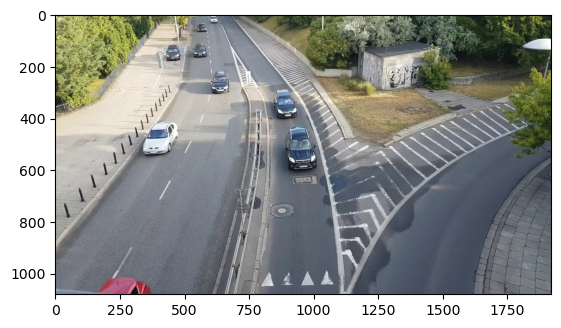

torch.Size([3, 3000, 2000])


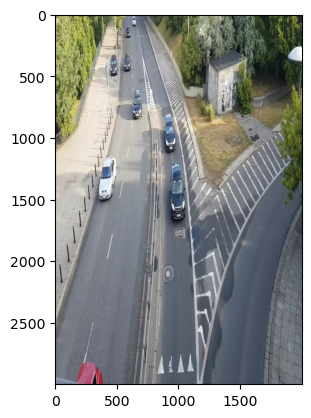

torch.Size([3, 1080, 720])


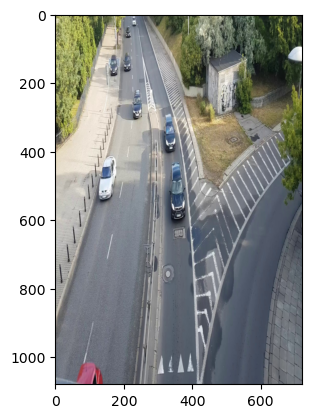

In [84]:
from torchvision.transforms import v2

curr_img = read_image("./data/object_detection_v1/train/images/frame_0000.jpg").int()
print(curr_img.shape)
plt.imshow(curr_img.numpy().transpose((1, 2, 0)))
plt.show()

resize_img = v2.Resize(size=(3000, 2000))(curr_img)

curr_img_color_chanels, curr_img_height, curr_img_width = resize_img.shape
img_downsize_raport = None
if curr_img_height > img_h:
    # downsize to 1080
    height_raport = 1080 / curr_img_height
    img_downsize_raport = height_raport

if curr_img_width > img_w:
    width_raport = 1920 / curr_img_width
    img_downsize_raport = min(img_downsize_raport, width_raport)
    
if img_downsize_raport is not None:
    curr_img = v2.Resize(size=(int(curr_img_height * img_downsize_raport),
                               int(curr_img_width * img_downsize_raport)))(resize_img)
    
 # TODO: image is reshape to the least downsize raport. Now it needs to add blackbars to match original shape then integrate into dataset.

print(resize_img.shape)

plt.imshow(resize_img.numpy().transpose((1, 2, 0)))
plt.show()

print(curr_img.shape)
plt.imshow(curr_img.numpy().transpose((1, 2, 0)))
plt.show()


In [214]:
## APPEND DOWN BORDER ###
original_img = torch.ones((1, 2, 2))
border = torch.zeros(1, 1, 2)
new_img = torch.cat((original_img, border), dim=1)
print(new_img)


## APPEND RIGHT BORDER ###

original_img = torch.ones((1, 2, 2))
border = torch.zeros(1, 2, 1)
new_img = torch.cat((original_img, border), dim=2)
print(new_img)

tensor([[[1., 1.],
         [1., 1.],
         [0., 0.]]])
tensor([[[1., 1., 0.],
         [1., 1., 0.]]])


In [34]:
(class ObjectDetectionDatasetV2(Dataset):
    def __init__(self, root, img_format=(None, None)):
        self.root = root
        self.images = list(sorted(os.listdir(self.root + 'images/')))
        self.labels = list(sorted(os.listdir(self.root + 'labels/')))
        self.img_w = img_format[0]
        self.img_h = img_format[1]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        curr_img = read_image(self.root + 'images/' + self.images[idx]).float() / 255.0
        curr_img_color_chanels, curr_img_height, curr_img_width = curr_img.shape
        # TODO: Add image processing to match self.img_format
                     
        
        label_path = self.root + 'labels/'+ self.labels[idx]
        boxes = []
        labels = []
        
        # Positive examples
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                _, x_center, y_center, width, height = map(float, data)
                
                # Convert relative coordinates to absolute coordinates
                x_center *= curr_img_width
                y_center *= curr_img_height
                width *= curr_img_width
                height *= curr_img_height
                
                # Calculate top-left and bottom-right coordinates
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                if (x2 > x1 and 
                        y2 > y1 and 
                        0 <= x1 < curr_img_width and 
                        0 <= y1 < curr_img_height and 
                        0 <= x2 < curr_img_width and 
                        0 <= y2 < curr_img_height):
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(1))
        
        # Negative examples ( get 20 positive example from each image )
        initial_size = len(boxes) * 2
        while len(boxes) < initial_size * 3:
            x1, y1, x2, y2 = generate_bounding_box(curr_img_height, curr_img_width)
            proposed_box = [x1, y1, x2, y2]

            skip_loop = False
            for box in boxes:
                if compute_iou(box, proposed_box) >= 0.4:
                    skip_loop = True
                    break
            if skip_loop:
                continue
            
            boxes.append(proposed_box)
            labels.append(int(0))
        
        boxes = torch.tensor(boxes, dtype=torch.float32, device=device)
        labels = torch.tensor(labels, dtype=torch.int64, device=device)
        curr_img = curr_img.to(device)
        target = {"boxes": boxes, "labels": labels}
        
        # if self.transform:
        #     img = self.transform(img)
        
        return curr_img, target

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# Load a pre-trained model
model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Define the number of classes (including the background)
num_classes = 2  # 1 class (object) + background

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
from tqdm import tqdm
import torch
import torch.optim as optim

# Move model to the right device
model.to(device)

# Parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=5e-4, momentum=0.9, weight_decay=5e-5)
num_epochs = 2

# Training loop
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    model.train()
    for images, targets in tqdm(train_dataloader_v1):
        loss_dict = model(images, targets)
        batch_losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        batch_losses.backward()
        optimizer.step()
        
        epoch_loss += batch_losses.item()

    # Calculate average loss
    average_loss = epoch_loss / (len(train_dataloader_v1))
    print(f"Epoch: {epoch}, Loss: {average_loss:.4f}")

100%|██████████| 133/133 [00:50<00:00,  2.61it/s]


Epoch: 1, Loss: 1.1694


100%|██████████| 133/133 [00:50<00:00,  2.64it/s]

Epoch: 2, Loss: 0.8107


In [13]:
torch.save(model.state_dict(), 'car_detection_model.pth')

In [14]:
model.load_state_dict(torch.load('car_detection_model.pth', map_location=device))

<All keys matched successfully>

In [16]:
import time
from matplotlib import patches
from IPython.core.display_functions import clear_output

detection_threshold = 0.6
model.eval()
for idx, (images, targets) in enumerate(val_dataloader_v1):
    outputs = model(images)

    for i, image in enumerate(images):
        np_image = image.permute(1, 2, 0).cpu().numpy()
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        labels = outputs[i]['labels'].data.cpu().numpy()


        plt.figure(figsize=(16, 9), dpi=100)
        plt.imshow(np_image)
        for box, score, label in zip(boxes, scores, labels):
            if score >= detection_threshold and label == 1:
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(x1, y1, f'{score:.2f}', color='black', fontsize=12, bbox=dict(facecolor='red', alpha=0.2))
        
        plt.show()
        time.sleep(0.2)
        clear_output()  

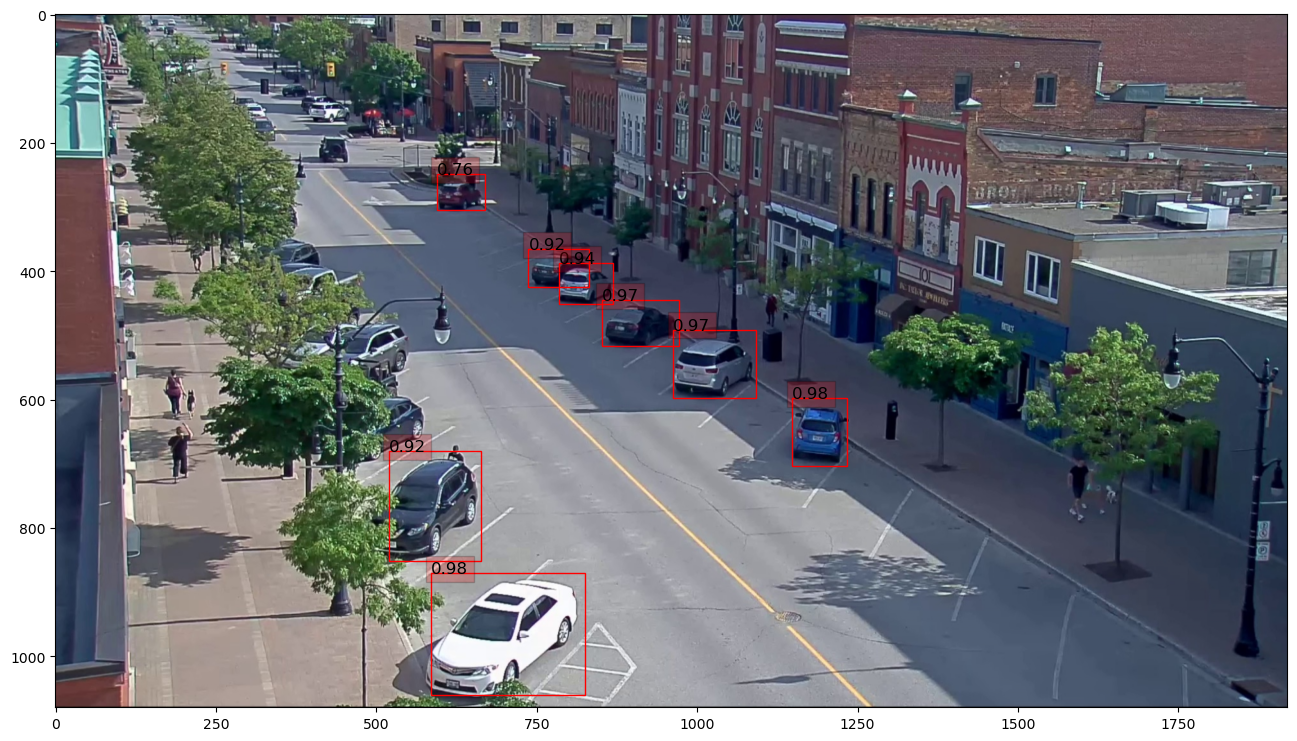

KeyboardInterrupt: 

In [17]:
import time
from matplotlib import patches
from IPython.core.display_functions import clear_output

for path in test_paths:

    curr_img = read_image(test_dir + path) / 255.0
    curr_img = img_transform(curr_img)
    curr_img = curr_img.unsqueeze(0)
    curr_img = curr_img.to(device)
    outputs = model(curr_img)
    
    curr_img = curr_img.squeeze(0)
    np_image = curr_img.permute(1, 2, 0).cpu().numpy()
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    labels = outputs[0]['labels'].data.cpu().numpy()


    plt.figure(figsize=(16, 9), dpi=100)
    plt.imshow(np_image)
    for box, score, label in zip(boxes, scores, labels):
        if score >= detection_threshold and label == 1:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1, f'{score:.2f}', color='black', fontsize=12, bbox=dict(facecolor='red', alpha=0.2))
    
    plt.show()
    time.sleep(2)
    clear_output()